In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
# import lime.lime_tabular as lime_tab
# import lime.lime_tabular_mod as lime_tab
import lime.lime_tabular_multiregressor as lime_tab

import matplotlib.pyplot as plt
import random

import importlib
importlib.reload(lime_tab)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
34,4.9,3.1,1.5,0.1,Iris-setosa
55,5.7,2.8,4.5,1.3,Iris-versicolor
28,5.2,3.4,1.4,0.2,Iris-setosa
52,6.9,3.1,4.9,1.5,Iris-versicolor
62,6.0,2.2,4.0,1.0,Iris-versicolor
...,...,...,...,...,...
12,4.8,3.0,1.4,0.1,Iris-setosa
145,6.7,3.0,5.2,2.3,Iris-virginica
9,4.9,3.1,1.5,0.1,Iris-setosa
77,6.7,3.0,5.0,1.7,Iris-versicolor


### Prepare dataset 

In [3]:
labels_column_name = "label"
# jackknife_idx = random.choice(iris_dataset.index.to_numpy())
jackknife_idx = 118
train_data = iris_dataset.loc[iris_dataset.index != jackknife_idx]
train_x = train_data.drop(columns=labels_column_name).to_numpy()
train_y = train_data[labels_column_name].to_numpy()
test_data = iris_dataset.loc[iris_dataset.index == jackknife_idx]
test_x = test_data.drop(columns=labels_column_name).to_numpy()
test_y = test_data[labels_column_name].to_numpy()

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
print(f"Attributes: {attributes}")

Attributes: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


In [4]:
model = sklearn.ensemble.RandomForestClassifier()
model.fit(train_x, train_y)

result = model.predict(test_x)
accuracy = sklearn.metrics.accuracy_score(test_y, result)
print(f"Predicted: {result}. It's accuracy: {accuracy}")

Predicted: ['Iris-virginica']. It's accuracy: 1.0


### Use LIME to explain local prediction

In [42]:
explainer = lime_tab.LTEMultiRegressionTree(
    train_x,
    feature_names = attributes,
    class_names = model.classes_,
    with_kfold = 5,
    discretize_continuous=False
)

Show probabilities for random instance (given by random forest on test dataset)

In [43]:
probabilities = model.predict_proba(test_x)[0,:]
probabilities_for_labels = {}
for label, probability in zip(model.classes_, probabilities):
    probabilities_for_labels[label] = probability
print(probabilities_for_labels)
predicted_label_id = np.argmax(probabilities)

{'Iris-setosa': 0.0, 'Iris-versicolor': 0.0, 'Iris-virginica': 1.0}


Explain the instance

array([0., 0., 1.])

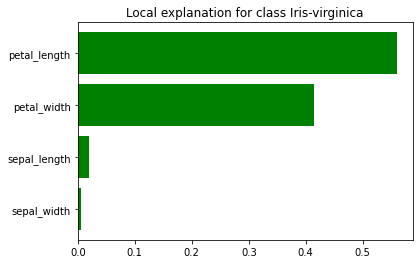

In [44]:
explanation = explainer.explain_instance(
    test_x.ravel(),
    model.predict_proba,
    num_features = 4,
    top_labels = 3
)
explanation.as_pyplot_figure(explanation.top_labels[0])
explanation.predict_proba   # probabilites from explained model

In [45]:
test_data

,sepal_length,sepal_width,petal_length,petal_width,label
118,7.7,2.6,6.9,2.3,Iris-virginica


In [46]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))

[0.0, 0.0, 1.0]
[0.0, 0.0, 1.0]
[0.0, 0.0, 1.0]


In [47]:
print("MSE on training set:", np.array(explanation.get_losses_for_surrogate_model()))
print("MSE on cv-test  set:", np.mean(explanation.get_losses_for_cv_model(), axis=1))
print("std on cv-test  set:", np.std(explanation.get_losses_for_cv_model(), axis=1))

MSE on training set: [8.37148302e-33 4.92546412e-33 2.17512421e-33]
MSE on cv-test  set: [0.00013658 0.00092918 0.00081476]
std on cv-test  set: [7.66627002e-05 1.04969336e-04 1.31212067e-04]


In [48]:
model.classes_

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [49]:
import pydotplus
import collections

In [51]:
plt.figure(figsize=(14,10))
sklearn.tree.plot_tree(
    explanation.local_surrogates_ensemble[2],
    feature_names=attributes,
    class_names=model.classes_,
    fontsize=10,
    rounded=True,
    label="root",
    impurity=False,
    proportion=True
)
plt.show()

KeyboardInterrupt: 

In [52]:
attributes

['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

In [54]:
a = test_x
# a = train_x[[0],:]
a

array([[7.7, 2.6, 6.9, 2.3]])

In [55]:
clf = explanation.local_surrogates_ensemble[2]
dot_data = sklearn.tree.export_graphviz(
    clf,
    feature_names=attributes,
    class_names=model.classes_,
    label="root",
    out_file=None,
    filled=True,
    impurity=False,
    proportion=True,
    rounded=True,
    rotate=True,
)
graph = pydotplus.graph_from_dot_data(dot_data)
colors = ('brown', 'forestgreen')
edges = collections.defaultdict(list)

# empty all nodes, i.e.set color to white
for node in graph.get_node_list():
    node.set_fillcolor('white')

decision_path = clf.decision_path(a)
for n, node_value in enumerate(decision_path.toarray()[0]):
    if node_value == 0:
        continue
    node = graph.get_node(str(n))[0]
    node.set_fillcolor('turquoise')

graph.write_png('tree.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.610129 to fit



True

<1x31 sparse matrix of type '<class 'numpy.int64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [18]:
explanation.get_fidelity_loss_on_kfold()

array([0.05750893, 0.0548121 , 0.05365606, 0.05338647, 0.05326154])

In [12]:
top_features = explanation.as_map()[explanation.top_labels[0]]
top_features

[(2, 0.5903434937850893),
 (3, 0.40035413174226253),
 (1, 0.0049878434636586155),
 (0, 0.004314531008989509)]

In [13]:
second_top_features = explanation.as_map()[explanation.top_labels[1]]
second_top_features

[(2, 0.6211525944468204),
 (3, 0.3454914638396597),
 (1, 0.019713363368740574),
 (0, 0.013642578344779513)]

In [14]:
explanation.as_map()

{0: [(2, 0.5416163008226225),
  (3, 0.45377513589531215),
  (0, 0.002396555782511594),
  (1, 0.0022120074995538317)],
 1: [(2, 0.6211525944468204),
  (3, 0.3454914638396597),
  (1, 0.019713363368740574),
  (0, 0.013642578344779513)],
 2: [(2, 0.5903434937850893),
  (3, 0.40035413174226253),
  (1, 0.0049878434636586155),
  (0, 0.004314531008989509)]}

In [15]:
explainer.discretizer.names

{0: ['sepal_length <= 5.10',
  '5.10 < sepal_length <= 5.80',
  '5.80 < sepal_length <= 6.40',
  'sepal_length > 6.40'],
 1: ['sepal_width <= 2.80',
  '2.80 < sepal_width <= 3.00',
  '3.00 < sepal_width <= 3.30',
  'sepal_width > 3.30'],
 2: ['petal_length <= 1.60',
  '1.60 < petal_length <= 4.30',
  '4.30 < petal_length <= 5.10',
  'petal_length > 5.10'],
 3: ['petal_width <= 0.30',
  '0.30 < petal_width <= 1.30',
  '1.30 < petal_width <= 1.80',
  'petal_width > 1.80']}

In [16]:
explainer.discretizer.maxs

{0: [5.1, 5.8, 6.4, 7.9],
 1: [2.8, 3.0, 3.3, 4.4],
 2: [1.6, 4.3, 5.1, 6.7],
 3: [0.3, 1.3, 1.8, 2.5]}

Update some attributes to see if probabilities would change

In [17]:
top_features = explanation.as_map()[predicted_label_id]
top_features

[(2, 0.5903434937850893),
 (3, 0.40035413174226253),
 (1, 0.0049878434636586155),
 (0, 0.004314531008989509)]